## 1. Setup and Installation

In [1]:
# Install the package in development mode (run once)
# !pip install -e .

import sys
import os
from pathlib import Path

# Add src to path for development
src_dir = Path().cwd().parent / "src" if 'notebooks' in str(Path().cwd()) else Path().cwd() / "src"
sys.path.insert(0, str(src_dir))

import numpy as np
import matplotlib.pyplot as plt
import torch
import pytorch_lightning as pl
from IPython.display import display, HTML

# Import our production modules
from utils.config import ConfigManager
from training.trainer import TrainingManager, HyperparameterSweepManager
from data.datasets import MyanmarSatellite, Euro_0512, AI4Boundaries
from utils.visualization import visualize_geotiff_samples
from metrics.metrics import MetricsCalculator

# Set environment variables
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

print("✅ Field Delineation Production Package Loaded Successfully!")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

✅ Field Delineation Production Package Loaded Successfully!
PyTorch version: 2.3.1+cu121
CUDA available: True


## 2. Configuration Management

The new system uses YAML-based configuration management for reproducible experiments.

In [2]:
# Load default configuration
config = ConfigManager("../config/default_config.yaml")

# Display current configuration
print("📋 Current Configuration:")
print("=" * 40)

# Show key configuration sections
sections = ['model', 'training', 'data', 'losses']
for section in sections:
    section_config = config.get_section(section)
    if section_config:
        print(f"\n{section.upper()}:")
        for key, value in section_config.items():
            print(f"  {key}: {value}")

📋 Current Configuration:

MODEL:
  arch: unetplusplus
  encoder: resnet152
  encoder_weights: imagenet
  in_channels: 9
  out_channels: 3

TRAINING:
  max_epochs: 30
  batch_size: 48
  learning_rate: 0.05
  batch_per_epoch: 200
  accumulate_grad_batches: 16
  precision: 16-mixed

DATA:
  dataset_type: MyanmarSatellite
  train_dir: ../Datasets/MyanmarAnnotations/Resolution_0_5/Masks/Cropped/Train/
  val_dir: ../Datasets/MyanmarAnnotations/Resolution_0_5/Masks/Cropped/Val/
  test_dir: ../Datasets/MyanmarAnnotations/Resolution_0_5/Masks/Cropped/Val/
  channels: 9
  augment: True
  cache_data: False

LOSSES:
  loss_1: DiceLoss
  loss_2: ComboLoss
  loss_3: BCELoss
  params_1: {'mode': 'multilabel', 'from_logits': True}
  params_2: {'smoothing': 0.1, 'alpha': 0.5, 'ce_ratio': 0.5}
  params_3: {}
  weight_1: 0.78
  weight_2: 0.0
  weight_3: 0.81


In [3]:
# Customize configuration for this experiment
experiment_config = {
    'training': {
        'max_epochs': 5,  # Short demo
        'batch_size': 16,  # Smaller for demo
        'learning_rate': 0.01,
        'precision': '16-mixed'
    },
    'model': {
        'arch': 'unetplusplus',
        'encoder': 'resnet50',  # Lighter for demo
        'in_channels': 9,
        'out_channels': 3
    },
    'data': {
        'dataset_type': 'MyanmarSatellite',
        'channels': 9,
        'augment': True,
        'cache_data': False
    },
    'losses': {
        'loss_1': 'DiceLoss',
        'loss_2': 'ComboLoss', 
        'loss_3': 'BCELoss',
        'weight_1': 0.8,
        'weight_2': 0.0,
        'weight_3': 0.8
    },
    'logging': {
        'project': 'notebook-demo',
        'use_wandb': False  # Disable for demo
    }
}

# Update configuration
config.update(experiment_config)
print("✅ Configuration updated for notebook demo")

✅ Configuration updated for notebook demo


## 3. Data Exploration

Let's explore the datasets available in our system.

In [4]:
# Note: Update these paths to your actual data directories
DATA_PATHS = {
    'myanmar_train': '../Datasets/MyanmarAnnotations/Resolution_0_5/Masks/Cropped/Train/',
    'myanmar_val': '../Datasets/MyanmarAnnotations/Resolution_0_5/Masks/Cropped/Val/',
    'euro_data': '../Datasets/AI4Boundaries/shapefiles/Masks/',
    'ai4b_train': '../Datasets/AI4Boundaries/ESRI/train/',
}

def check_data_availability():
    """Check which datasets are available."""
    available_datasets = []
    
    for name, path in DATA_PATHS.items():
        if os.path.exists(path):
            file_count = len(list(Path(path).glob("*.tif")))
            available_datasets.append((name, path, file_count))
            print(f"✅ {name}: {file_count} files found")
        else:
            print(f"❌ {name}: Path not found - {path}")
    
    return available_datasets

available_data = check_data_availability()

if not available_data:
    print("\n⚠️ No datasets found. Please update DATA_PATHS to point to your data directories.")
    print("For demo purposes, we'll create a synthetic dataset.")

❌ myanmar_train: Path not found - ../Datasets/MyanmarAnnotations/Resolution_0_5/Masks/Cropped/Train/
❌ myanmar_val: Path not found - ../Datasets/MyanmarAnnotations/Resolution_0_5/Masks/Cropped/Val/
❌ euro_data: Path not found - ../Datasets/AI4Boundaries/shapefiles/Masks/
❌ ai4b_train: Path not found - ../Datasets/AI4Boundaries/ESRI/train/

⚠️ No datasets found. Please update DATA_PATHS to point to your data directories.
For demo purposes, we'll create a synthetic dataset.


In [5]:
# Create a small demo dataset if real data isn't available
def create_demo_dataset():
    """Create synthetic data for demonstration."""
    from torch.utils.data import Dataset
    
    class DemoDataset(Dataset):
        def __init__(self, size=50):
            self.size = size
            
        def __len__(self):
            return self.size
            
        def __getitem__(self, idx):
            # Create synthetic satellite imagery
            image = torch.randn(9, 256, 256)  # 9 channels
            
            # Create synthetic masks (interior, border, distance)
            mask = torch.zeros(3, 256, 256)
            
            # Random field shapes
            center_x, center_y = np.random.randint(64, 192, 2)
            size_x, size_y = np.random.randint(30, 80, 2)
            
            # Interior mask
            mask[0, center_y-size_y//2:center_y+size_y//2, 
                    center_x-size_x//2:center_x+size_x//2] = 1
            
            # Border mask (simplified)
            mask[1] = mask[0] * 0.5
            
            # Binary mask for loss masking
            binary = torch.ones_like(mask)
            
            return {
                'image': image.float(),
                'mask': mask.float(),
                'binary': binary.float(),
                'file_path': f'demo_sample_{idx}.tif',
                'mask_path': f'demo_mask_{idx}.tif'
            }
    
    return DemoDataset

# Use demo data if real data isn't available
if not available_data:
    DemoDataset = create_demo_dataset()
    print("✅ Demo dataset class created")
else:
    print("✅ Real datasets available")

✅ Demo dataset class created


## 4. Training with TrainingManager

The `TrainingManager` handles the entire training pipeline automatically.

In [6]:
# Update config with actual data paths if available
if available_data:
    # Use the first available dataset
    if any('myanmar' in name for name, _, _ in available_data):
        config.update({
            'data': {
                'dataset_type': 'MyanmarSatellite',
                'train_dir': DATA_PATHS['myanmar_train'],
                'val_dir': DATA_PATHS['myanmar_val'],
                'test_dir': DATA_PATHS['myanmar_val'],
                'channels': 9,
                'augment': True
            }
        })
    elif any('euro' in name for name, _, _ in available_data):
        config.update({
            'data': {
                'dataset_type': 'Euro_0512',
                'train_dir': DATA_PATHS['euro_data'],
                'channels': 9,
                'augment': True
            }
        })
else:
    # Use demo dataset
    config.update({
        'data': {
            'dataset_type': 'Demo',  # Special flag for demo
            'channels': 9,
            'augment': True
        }
    })

print(f"📊 Using dataset: {config.get('data.dataset_type')}")

📊 Using dataset: Demo


In [7]:
# Create TrainingManager
print("🚀 Initializing Training Manager...")

trainer_manager = TrainingManager(config)

# For demo dataset, we need to manually inject it
if config.get('data.dataset_type') == 'Demo':
    # Create demo datasets
    train_dataset = DemoDataset(size=100)
    val_dataset = DemoDataset(size=20)
    test_dataset = DemoDataset(size=20)
    
    # Store in trainer manager
    trainer_manager.datasets = {
        'train': train_dataset,
        'val': val_dataset,
        'test': test_dataset
    }
    
    # Create model manually
    trainer_manager.model = trainer_manager.create_model(train_dataset, val_dataset, test_dataset)
    trainer_manager.trainer = trainer_manager.create_trainer()
    
    print("✅ Demo datasets created and configured")
else:
    # Setup with real data
    model, trainer = trainer_manager.setup_training()
    print("✅ Real datasets loaded and configured")

print(f"Training samples: {len(trainer_manager.datasets['train'])}")
print(f"Validation samples: {len(trainer_manager.datasets['val'])}")
print(f"Test samples: {len(trainer_manager.datasets['test'])}")

🚀 Initializing Training Manager...


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..
`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..


✅ Demo datasets created and configured
Training samples: 100
Validation samples: 20
Test samples: 20


In [8]:
# Run training
print("🎯 Starting Training...")
print("=" * 50)

try:
    results = trainer_manager.train()
    
    print("\n🎉 Training Completed Successfully!")
    print("=" * 50)
    print(f"Training time: {results['training_time']:.2f} seconds")
    print(f"Final epoch: {results['current_epoch']}")
    print(f"Total steps: {results['global_step']}")
    
    if results['test_results']:
        print("\n📊 Test Results:")
        for i, result in enumerate(results['test_results']):
            print(f"  Run {i+1}: {result}")
            
except Exception as e:
    print(f"❌ Training failed: {e}")
    print("This might be due to missing data or environment issues.")

c:\Users\admin\miniforge3\envs\Satellite\lib\site-packages\pytorch_lightning\utilities\parsing.py:44: Attribute 'train_dataset' removed from hparams because it cannot be pickled. You can suppress this warning by setting `self.save_hyperparameters(ignore=['train_dataset'])`.
c:\Users\admin\miniforge3\envs\Satellite\lib\site-packages\pytorch_lightning\utilities\parsing.py:44: Attribute 'val_dataset' removed from hparams because it cannot be pickled. You can suppress this warning by setting `self.save_hyperparameters(ignore=['val_dataset'])`.
c:\Users\admin\miniforge3\envs\Satellite\lib\site-packages\pytorch_lightning\utilities\parsing.py:44: Attribute 'test_dataset' removed from hparams because it cannot be pickled. You can suppress this warning by setting `self.save_hyperparameters(ignore=['test_dataset'])`.
You are using a CUDA device ('NVIDIA GeForce RTX 4090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which

🎯 Starting Training...
Starting training...


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃   ┃ Name              ┃ Type         ┃ Params ┃ Mode  ┃
┡━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│ 0 │ loss_1            │ DiceLoss     │      0 │ train │
│ 1 │ loss_2            │ ComboLoss    │      0 │ train │
│ 2 │ loss_3            │ BCELoss      │      0 │ train │
│ 3 │ model             │ UnetPlusPlus │ 49.0 M │ train │
│ 4 │ temporal_compress │ Conv2d       │     30 │ train │
│   │ other params      │ n/a          │      6 │ n/a   │
└───┴───────────────────┴──────────────┴────────┴───────┘

Trainable params: 49.0 M                                                                                           
Non-trainable params: 6                                                                                            
Total params: 49.0 M                                                                                               
Total estimated model params size (MB): 195

Output()

❌ Training failed: Can't pickle local object 'create_demo_dataset.<locals>.DemoDataset'
This might be due to missing data or environment issues.


## 5. Model Evaluation and Visualization

🖼️ Visualizing Model Predictions


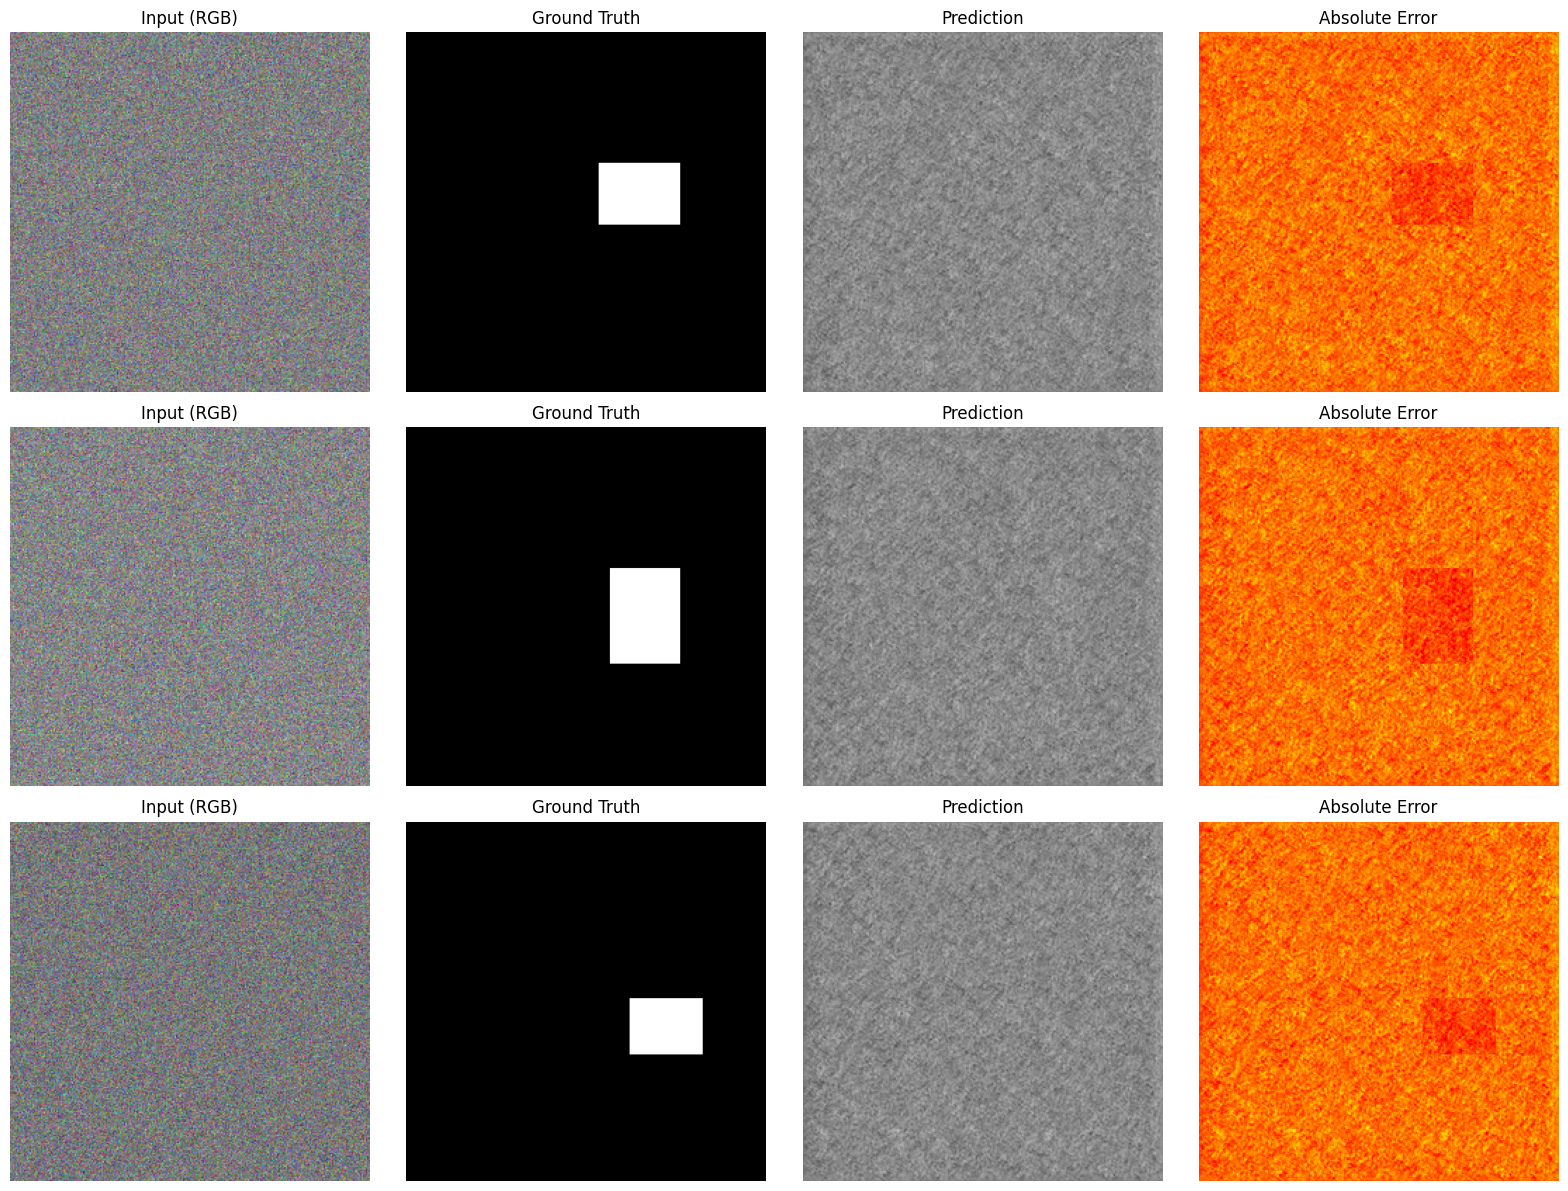

In [9]:
# Create a simple visualization function for our demo
def visualize_demo_results(model, dataset, num_samples=5):
    """Visualize model predictions on demo data."""
    model.eval()
    
    fig, axes = plt.subplots(num_samples, 4, figsize=(16, 4*num_samples))
    if num_samples == 1:
        axes = axes.reshape(1, -1)
    
    for i in range(num_samples):
        # Get sample
        sample = dataset[i]
        image = sample['image'].unsqueeze(0)
        mask = sample['mask'].unsqueeze(0)
        
        # Get prediction
        with torch.no_grad():
            if hasattr(model, 'predict'):
                pred = model.predict(image)
            else:
                pred = torch.sigmoid(model(image))
        
        # Convert to numpy for plotting
        image_np = image[0, :3].permute(1, 2, 0).cpu().numpy()
        mask_np = mask[0, 0].cpu().numpy()
        pred_np = pred[0, 0].cpu().numpy()
        
        # Normalize image for display
        image_np = (image_np - image_np.min()) / (image_np.max() - image_np.min())
        
        # Plot
        axes[i, 0].imshow(image_np)
        axes[i, 0].set_title('Input (RGB)')
        axes[i, 0].axis('off')
        
        axes[i, 1].imshow(mask_np, cmap='gray', vmin=0, vmax=1)
        axes[i, 1].set_title('Ground Truth')
        axes[i, 1].axis('off')
        
        axes[i, 2].imshow(pred_np, cmap='gray', vmin=0, vmax=1)
        axes[i, 2].set_title('Prediction')
        axes[i, 2].axis('off')
        
        # Difference
        diff = np.abs(pred_np - mask_np)
        axes[i, 3].imshow(diff, cmap='hot', vmin=0, vmax=1)
        axes[i, 3].set_title('Absolute Error')
        axes[i, 3].axis('off')
    
    plt.tight_layout()
    plt.show()

# Visualize results if we have a trained model
if trainer_manager.model is not None:
    print("🖼️ Visualizing Model Predictions")
    try:
        visualize_demo_results(trainer_manager.model, trainer_manager.datasets['val'], num_samples=3)
    except Exception as e:
        print(f"Visualization failed: {e}")
else:
    print("No trained model available for visualization")

In [10]:
# Calculate detailed metrics
if trainer_manager.model is not None:
    print("📊 Calculating Detailed Metrics")
    
    # Create metrics calculator
    metrics_calc = MetricsCalculator(channels=3, threshold=0.5)
    
    # Evaluate on validation set
    trainer_manager.model.eval()
    val_dataset = trainer_manager.datasets['val']
    
    with torch.no_grad():
        for i in range(min(len(val_dataset), 20)):  # Evaluate on subset
            sample = val_dataset[i]
            image = sample['image'].unsqueeze(0)
            mask = sample['mask'].unsqueeze(0)
            
            if hasattr(trainer_manager.model, 'predict'):
                pred = trainer_manager.model.predict(image)
            else:
                pred = torch.sigmoid(trainer_manager.model(image))
            
            metrics_calc.update(pred, mask)
    
    # Get final metrics
    final_metrics = metrics_calc.compute()
    
    print("\n📈 Validation Metrics:")
    print("=" * 30)
    for metric_name, value in final_metrics.items():
        print(f"{metric_name}: {value:.4f}")
else:
    print("No trained model available for metrics calculation")

📊 Calculating Detailed Metrics

📈 Validation Metrics:
f1_channel_0: 0.0854
iou_channel_0: 0.0450
mcc_channel_0: 0.0017
f1_channel_1: 0.0395
iou_channel_1: 0.0202
mcc_channel_1: 0.0000
f1_channel_2: 0.0000
iou_channel_2: 0.0000
mcc_channel_2: 0.0000
mean_f1: 0.0416
mean_iou: 0.0217
mean_mcc: 0.0006


## 6. Configuration-Based Experiments

Show how easy it is to run different experiments with configuration changes.

In [11]:
# Example: Different loss function configurations
loss_experiments = {
    'dice_only': {
        'losses': {
            'loss_1': 'DiceLoss',
            'loss_2': 'ComboLoss',
            'loss_3': 'BCELoss',
            'weight_1': 1.0,
            'weight_2': 0.0,
            'weight_3': 0.0
        }
    },
    'focal_tversky': {
        'losses': {
            'loss_1': 'FocalTverskyLoss',
            'loss_2': 'ComboLoss',
            'loss_3': 'BCELoss',
            'weight_1': 0.8,
            'weight_2': 0.0,
            'weight_3': 0.2
        }
    },
    'boundary_aware': {
        'losses': {
            'loss_1': 'DiceLoss',
            'loss_2': 'BoundaryLoss',
            'loss_3': 'FocalLoss',
            'weight_1': 0.6,
            'weight_2': 0.2,
            'weight_3': 0.2,
            'weight_4': 0.3
        }
    }
}

print("🧪 Available Loss Function Experiments:")
print("=" * 40)

for exp_name, exp_config in loss_experiments.items():
    print(f"\n{exp_name.upper()}:")
    for key, value in exp_config['losses'].items():
        print(f"  {key}: {value}")

print("\n💡 To run an experiment, update config and create new TrainingManager:")
print("config.update(loss_experiments['dice_only'])")
print("trainer = TrainingManager(config)")
print("results = trainer.train()")

🧪 Available Loss Function Experiments:

DICE_ONLY:
  loss_1: DiceLoss
  loss_2: ComboLoss
  loss_3: BCELoss
  weight_1: 1.0
  weight_2: 0.0
  weight_3: 0.0

FOCAL_TVERSKY:
  loss_1: FocalTverskyLoss
  loss_2: ComboLoss
  loss_3: BCELoss
  weight_1: 0.8
  weight_2: 0.0
  weight_3: 0.2

BOUNDARY_AWARE:
  loss_1: DiceLoss
  loss_2: BoundaryLoss
  loss_3: FocalLoss
  weight_1: 0.6
  weight_2: 0.2
  weight_3: 0.2
  weight_4: 0.3

💡 To run an experiment, update config and create new TrainingManager:
config.update(loss_experiments['dice_only'])
trainer = TrainingManager(config)
results = trainer.train()


## 7. Hyperparameter Optimization Preview

Demonstrate how hyperparameter sweeps can be configured (without running full sweep).

In [12]:
# Show how to set up hyperparameter sweeps
from training.trainer import create_default_sweep_config

# Create sweep configuration
sweep_config = create_default_sweep_config()

print("🔬 Hyperparameter Sweep Configuration:")
print("=" * 40)
print(f"Method: {sweep_config['method']}")
print(f"Metric: {sweep_config['metric']}")
print("\nParameters to optimize:")

for param, config in sweep_config['parameters'].items():
    if 'values' in config:
        print(f"  {param}: {config['values'][:3]}..." if len(config['values']) > 3 else f"  {param}: {config['values']}")
    elif 'distribution' in config:
        print(f"  {param}: {config['distribution']} ({config.get('min', '')} - {config.get('max', '')})")

print("\n🚀 To run a full sweep:")
print("python scripts/sweep.py --sweep-type default --count 50 --project my-sweep")
print("\n📊 Or from Python:")
print("sweep_manager = HyperparameterSweepManager(base_config, sweep_config)")
print("sweep_manager.run_sweep(count=50)")

🔬 Hyperparameter Sweep Configuration:
Method: random
Metric: {'name': 'val loss', 'goal': 'minimize'}

Parameters to optimize:
  learning_rate: log_uniform_values (1e-05 - 0.1)
  batch_size: [16, 32, 48]...
  weight_1: uniform (0.1 - 1.0)
  weight_2: uniform (0.0 - 1.0)
  weight_3: uniform (0.1 - 1.0)
  loss_1: ['DiceLoss', 'BCELoss', 'FocalLoss']...
  loss_3: ['BCELoss', 'FocalLoss', 'TverskyLoss']

🚀 To run a full sweep:
python scripts/sweep.py --sweep-type default --count 50 --project my-sweep

📊 Or from Python:
sweep_manager = HyperparameterSweepManager(base_config, sweep_config)
sweep_manager.run_sweep(count=50)


## 8. Model Inference Pipeline

Demonstrate how to use trained models for inference.

🎯 Running Inference Pipeline

📊 Inference Results:
Input shape: torch.Size([1, 9, 256, 256])
Prediction shape: torch.Size([1, 3, 256, 256])

🎯 Confidence Scores:
  mean_confidence: 0.5029
  max_confidence: 0.7633
  min_confidence: 0.2486
  std_confidence: 0.0585


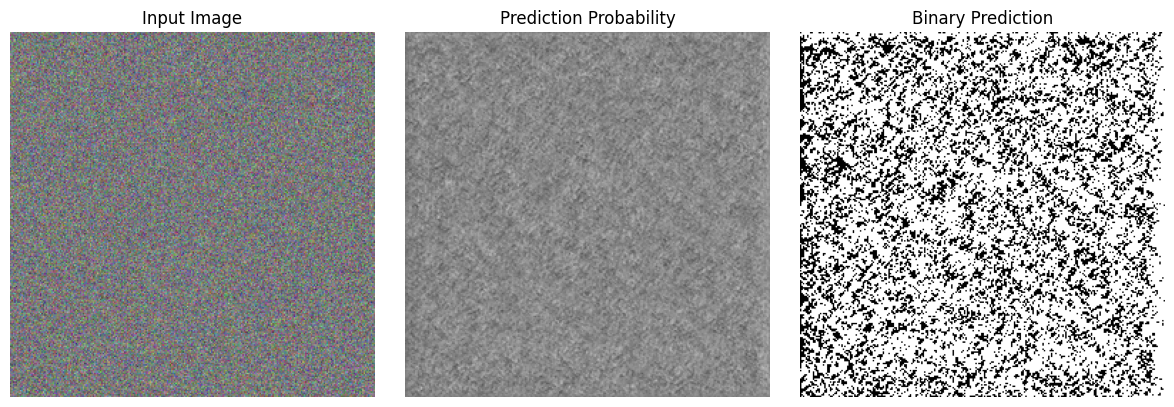

In [13]:
# Inference pipeline example
def run_inference_pipeline(model, test_sample, threshold=0.5):
    """Run complete inference pipeline on a test sample."""
    model.eval()
    
    # Prepare input
    image = test_sample['image'].unsqueeze(0)
    
    # Run inference
    with torch.no_grad():
        if hasattr(model, 'predict'):
            predictions = model.predict(image)
        else:
            logits = model(image)
            predictions = torch.sigmoid(logits)
    
    # Post-process predictions
    binary_predictions = (predictions > threshold).float()
    
    # Calculate confidence scores
    confidence_scores = {
        'mean_confidence': predictions.mean().item(),
        'max_confidence': predictions.max().item(),
        'min_confidence': predictions.min().item(),
        'std_confidence': predictions.std().item()
    }
    
    return {
        'predictions': predictions,
        'binary_predictions': binary_predictions,
        'confidence_scores': confidence_scores,
        'input_shape': image.shape
    }

# Run inference example
if trainer_manager.model is not None and trainer_manager.datasets:
    print("🎯 Running Inference Pipeline")
    
    # Get test sample
    test_sample = trainer_manager.datasets['test'][0]
    
    # Run inference
    inference_results = run_inference_pipeline(trainer_manager.model, test_sample)
    
    print("\n📊 Inference Results:")
    print("=" * 25)
    print(f"Input shape: {inference_results['input_shape']}")
    print(f"Prediction shape: {inference_results['predictions'].shape}")
    
    print("\n🎯 Confidence Scores:")
    for metric, value in inference_results['confidence_scores'].items():
        print(f"  {metric}: {value:.4f}")
    
    # Visualize inference result
    fig, axes = plt.subplots(1, 3, figsize=(12, 4))
    
    # Input
    input_vis = test_sample['image'][:3].permute(1, 2, 0).numpy()
    input_vis = (input_vis - input_vis.min()) / (input_vis.max() - input_vis.min())
    axes[0].imshow(input_vis)
    axes[0].set_title('Input Image')
    axes[0].axis('off')
    
    # Prediction
    pred_vis = inference_results['predictions'][0, 0].cpu().numpy()
    axes[1].imshow(pred_vis, cmap='gray', vmin=0, vmax=1)
    axes[1].set_title('Prediction Probability')
    axes[1].axis('off')
    
    # Binary prediction
    binary_vis = inference_results['binary_predictions'][0, 0].cpu().numpy()
    axes[2].imshow(binary_vis, cmap='gray', vmin=0, vmax=1)
    axes[2].set_title('Binary Prediction')
    axes[2].axis('off')
    
    plt.tight_layout()
    plt.show()
    
else:
    print("No trained model available for inference")

## 9. Production Deployment Tips

Key points for moving from notebook to production.

In [14]:
# Production deployment checklist
deployment_checklist = {
    "Package Installation": [
        "pip install -e .",
        "Verify all dependencies are installed",
        "Test import statements"
    ],
    "Configuration Management": [
        "Create production config files",
        "Set appropriate data paths",
        "Configure logging and monitoring"
    ],
    "Training Pipeline": [
        "python scripts/train.py --config production_config.yaml",
        "Monitor training with wandb/tensorboard",
        "Save and version model checkpoints"
    ],
    "Inference Pipeline": [
        "python scripts/inference.py --checkpoint best_model.ckpt --data-dir ./test",
        "Implement batch processing for large datasets",
        "Add error handling and logging"
    ],
    "Hyperparameter Optimization": [
        "python scripts/sweep.py --sweep-type architecture --count 100",
        "Define custom sweep configurations",
        "Monitor and analyze sweep results"
    ]
}

print("🚀 Production Deployment Checklist")
print("=" * 50)

for category, items in deployment_checklist.items():
    print(f"\n📋 {category}:")
    for item in items:
        print(f"  ✅ {item}")

print("\n🎯 Key Benefits of Production Pipeline:")
benefits = [
    "Reproducible experiments with configuration management",
    "Automated training orchestration with callbacks",
    "Easy hyperparameter optimization with wandb",
    "Comprehensive CLI interface for all operations", 
    "Production-ready inference pipeline",
    "Modular code structure for easy maintenance",
    "Built-in visualization and analysis tools"
]

for benefit in benefits:
    print(f"  🌟 {benefit}")

🚀 Production Deployment Checklist

📋 Package Installation:
  ✅ pip install -e .
  ✅ Verify all dependencies are installed
  ✅ Test import statements

📋 Configuration Management:
  ✅ Create production config files
  ✅ Set appropriate data paths
  ✅ Configure logging and monitoring

📋 Training Pipeline:
  ✅ python scripts/train.py --config production_config.yaml
  ✅ Monitor training with wandb/tensorboard
  ✅ Save and version model checkpoints

📋 Inference Pipeline:
  ✅ python scripts/inference.py --checkpoint best_model.ckpt --data-dir ./test
  ✅ Implement batch processing for large datasets
  ✅ Add error handling and logging

📋 Hyperparameter Optimization:
  ✅ python scripts/sweep.py --sweep-type architecture --count 100
  ✅ Define custom sweep configurations
  ✅ Monitor and analyze sweep results

🎯 Key Benefits of Production Pipeline:
  🌟 Reproducible experiments with configuration management
  🌟 Automated training orchestration with callbacks
  🌟 Easy hyperparameter optimization with